In [48]:
import altair as alt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import defaultdict

## Load Data from CSV

In [10]:
# load TPM data
tpm_data_file = 'data/TPM_counts.tsv'
sample2condition_file = 'data/sample2condition.txt'
diagnostic_genes_file = 'data/diagnostic_genes.csv'
unstable_diag_genes_file = 'data/unstable_diagnostic_expression.csv'

# load TPM data
df = pd.read_csv(tpm_data_file,sep='\t').fillna('')

    
# load mapping from sample to condition
with open(sample2condition_file,'r') as f:
    sample2condition = dict(x.strip().split() for x in f.readlines())
    
# load data for diagnostic genes:
df_diagnostics = pd.read_csv(diagnostic_genes_file)
df_diagnostics['Gene'] = df_diagnostics['Gene'].apply(lambda x: "EQU24_RS20550" if x == "MBURv2_160514" else x)
df_diagnostics


# Mission: Reorganize dataset into 98x4213 dataframe where
#     --> columns represent each locus
#     --> rows represent each sample present

df_raw_tpm = df.iloc[:, 10:].T
loci = df["locus_tag"]
df_raw_tpm = df_raw_tpm.set_axis(loci, axis = 1).T

df_raw_tpm 

,5GB1_ferm_Ack_QC_tpm,5GB1_ferm_WT_QC_tpm,5GB1_FM03_TR1_QC_tpm,5GB1_FM03_TR2_QC_tpm,5GB1_FM11_TR1_QC_tpm,5GB1_FM11_TR2_QC_tpm,5GB1_FM12_TR1_tpm,5GB1_FM12_TR1_QC_tpm,5GB1_FM12_TR2_tpm,5GB1_FM12_TR2_QC_tpm,...,5GB1_pA9_red_tpm,5GB1_pA9_yellow_tpm,5GB1C-5G-La-BR1_tpm,5GB1C-5G-La-BR2_tpm,5GB1C-5G-N-BR1_tpm,5GB1C-5G-N-BR2_tpm,5GB1C-JG15-La-BR1_tpm,5GB1C-JG15-La-BR2_tpm,5GB1C-JG15-N-BR1_tpm,5GB1C-JG15-N-BR2_tpm
locus_tag,,,,,,,,,,,,,,,,,,,,,
EQU24_RS00005,2.933003,6.033848,48.864921,52.197450,25.751902,34.928170,28.322788,28.461759,28.479425,29.472757,...,38.557373,38.810668,37.444214,40.246006,40.100118,33.432274,39.880174,38.355431,30.247582,41.248441
EQU24_RS00010,1.607784,3.895284,51.315629,54.947425,37.216017,40.094206,27.387700,28.648564,26.498988,26.821965,...,52.552767,52.461746,42.676553,49.210083,46.798476,48.142385,45.465136,46.498139,37.152951,52.902410
EQU24_RS00015,1.415515,2.549771,33.906257,29.979783,21.716802,27.871558,16.570863,15.562811,16.589291,16.958650,...,31.350991,34.914128,21.479309,24.204682,22.171104,22.006566,22.658157,22.753325,19.407103,29.834124
EQU24_RS00020,3.200081,4.301580,64.584281,72.717824,53.032824,55.595529,36.795081,36.401903,37.513079,35.833478,...,74.848501,80.850761,54.959319,64.911376,59.653059,64.648318,69.119079,65.643179,57.590223,68.306759
EQU24_RS00025,1.522728,3.797084,74.801354,62.709260,46.348014,57.992363,27.432559,30.380176,26.852591,26.467246,...,50.324948,49.349547,34.539657,36.521074,37.789611,39.358066,38.992158,35.870964,41.462392,40.227192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EQU24_RS22135,2.300157,3.217944,104.488835,103.864151,78.264069,59.685923,58.833576,57.223346,66.382013,69.196352,...,70.918047,92.044879,20.691249,26.000334,20.753333,30.766617,22.101468,19.753259,20.027390,24.508375
EQU24_RS22140,5.261582,12.526353,379.686212,401.742811,208.094267,210.820167,204.760175,204.759505,211.282600,218.557992,...,328.789579,403.009110,105.587429,138.423469,100.648922,166.101675,96.169044,93.527806,89.780995,130.851229
EQU24_RS22145,9.389775,21.072962,500.129230,495.262554,260.011454,331.355028,300.766500,309.148602,312.637538,317.603906,...,301.203428,329.903989,69.198876,75.440610,62.460976,59.523445,47.641158,60.667488,55.739018,66.415222


In [13]:
# Preprocessing before clustering

scalar = StandardScaler()
scaled_tpm_data = scalar.fit_transform(df_raw_tpm)
df_scaled_tpm = pd.DataFrame(data= scaled_tpm_data, index = df_raw_tpm.index, 
                                columns= df_raw_tpm.columns)
df_scaled_tpm

,5GB1_ferm_Ack_QC_tpm,5GB1_ferm_WT_QC_tpm,5GB1_FM03_TR1_QC_tpm,5GB1_FM03_TR2_QC_tpm,5GB1_FM11_TR1_QC_tpm,5GB1_FM11_TR2_QC_tpm,5GB1_FM12_TR1_tpm,5GB1_FM12_TR1_QC_tpm,5GB1_FM12_TR2_tpm,5GB1_FM12_TR2_QC_tpm,...,5GB1_pA9_red_tpm,5GB1_pA9_yellow_tpm,5GB1C-5G-La-BR1_tpm,5GB1C-5G-La-BR2_tpm,5GB1C-5G-N-BR1_tpm,5GB1C-5G-N-BR2_tpm,5GB1C-JG15-La-BR1_tpm,5GB1C-JG15-La-BR2_tpm,5GB1C-JG15-N-BR1_tpm,5GB1C-JG15-N-BR2_tpm
locus_tag,,,,,,,,,,,,,,,,,,,,,
EQU24_RS00005,-0.022822,-0.024095,-0.053279,-0.053205,-0.043901,-0.051028,-0.044245,-0.044109,-0.045185,-0.045064,...,-0.056429,-0.053114,-0.050072,-0.061044,-0.063257,-0.067378,-0.062250,-0.061300,-0.062224,-0.078089
EQU24_RS00010,-0.022951,-0.024318,-0.052586,-0.052414,-0.041522,-0.049726,-0.044443,-0.044069,-0.045613,-0.045639,...,-0.052457,-0.049462,-0.048762,-0.058268,-0.061109,-0.062517,-0.060489,-0.058792,-0.060150,-0.073448
EQU24_RS00015,-0.022969,-0.024458,-0.057507,-0.059589,-0.044738,-0.052807,-0.046733,-0.046832,-0.047757,-0.047777,...,-0.058475,-0.054157,-0.054071,-0.066012,-0.069006,-0.071153,-0.067678,-0.066106,-0.065481,-0.082634
EQU24_RS00020,-0.022796,-0.024276,-0.048836,-0.047308,-0.038241,-0.045818,-0.042452,-0.042432,-0.043231,-0.043685,...,-0.046128,-0.041868,-0.045685,-0.053406,-0.056987,-0.057064,-0.053033,-0.052894,-0.054010,-0.067315
EQU24_RS00025,-0.022959,-0.024328,-0.045948,-0.050184,-0.039628,-0.045214,-0.044434,-0.043703,-0.045537,-0.045716,...,-0.053089,-0.050295,-0.050800,-0.062198,-0.063998,-0.065420,-0.062530,-0.062065,-0.058855,-0.078495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EQU24_RS22135,-0.022883,-0.024388,-0.037557,-0.038359,-0.033006,-0.044787,-0.037787,-0.038036,-0.036986,-0.036453,...,-0.047244,-0.038873,-0.054268,-0.065456,-0.069461,-0.068258,-0.067854,-0.067030,-0.065295,-0.084754
EQU24_RS22140,-0.022595,-0.023419,0.040229,0.047233,-0.006072,-0.006690,-0.006900,-0.006884,-0.005641,-0.004076,...,0.025952,0.044313,-0.033005,-0.030640,-0.043840,-0.023544,-0.044506,-0.044305,-0.044338,-0.042410
EQU24_RS22145,-0.022193,-0.022529,0.074272,0.074105,0.004699,0.023694,0.013421,0.015158,0.016284,0.017395,...,0.018121,0.024756,-0.042119,-0.050145,-0.056086,-0.058757,-0.059803,-0.054427,-0.054566,-0.068068


### K-Means Clustering
***

#### init 
controls the initialization technique. The standard version of the k-means algorithm is implemented by setting init to "random". Setting this to "k-means++" employs an advanced trick to speed up convergence

#### n_clusters 
sets k for the clustering step. This is the most important parameter for k-means.

#### n_init 
sets the number of initializations to perform. This is important because two runs can converge on different cluster assignments. The default behavior for the scikit-learn algorithm is to perform ten k-means runs and return the results of the one with the lowest SSE.

#### max_iter 
sets the number of maximum iterations for each initialization of the k-means algorithm.

##### source: https://realpython.com/k-means-clustering-python/#how-to-perform-k-means-clustering-in-python

In [21]:
# kmeans --> how many k clusters do we wish to discover? elbow or sillhouette methods


kmeans = KMeans(
            init = "k-means++",  # Notice: when init is no longer random, inertia lower
            n_clusters = 15,
            n_init = 10, 
            max_iter = 300, 
            random_state=42)

fitted = kmeans.fit(df_scaled_tpm)

#inertia is quite high --> not the ideal set of clusters here
fitted.inertia_


1534.0874652311272

## Finding number of clusters 
***

### Elbow Method

In [25]:
# variable-length argument list: keeps track of constant kmeans properties

kwargs_for_kmeans = {
            "init" : "k-means++",  
            "n_init" : 10, 
            "max_iter" : 300, 
            "random_state" : 42}
kwargs_for_kmeans

{'init': 'k-means++', 'n_init': 10, 'max_iter': 300, 'random_state': 42}

In [41]:
# Sum of squared error --> evaluate the qualuty of the clusters
sum_squared_error = []

for k_cluster_num in range(5, 30):
    kmeans = KMeans(n_clusters=k_cluster_num, **kwargs_for_kmeans)
    kmeans.fit(df_scaled_tpm)
    sum_squared_error.append(kmeans.inertia_)

[Text(0.5, 0, 'Number of Clusters (k)'),
 Text(0, 0.5, 'Sum Squared Error'),
 Text(0.5, 1.0, 'Elbow Plot for kmeans clustering')]

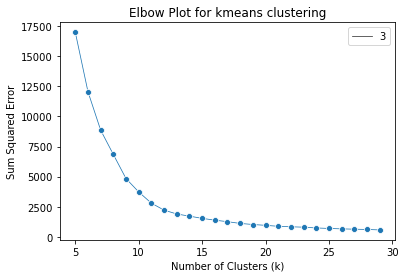

In [45]:
# Plot the elbow
elbow_plot = sns.lineplot(x = range(5, 30), y = sum_squared_error, 
                          marker="o", size=3)

elbow_plot.set(xlabel = "Number of Clusters (k)", ylabel = 
               "Sum Squared Error", title = "Elbow Plot for KMeans Clusters")

# NOTE: for programmatic detection of the elbow point, the "kneed" package 
#        can be of use!

### Sillhouette Coefficient Method

"quantifies how well a data point fits into its assigned cluster" ~ source above

they range from -1 to 1, and larger, the closer the samples are to their clusters than others. Thus, for a sillhoutte score, we need at least two clusters to compare from.

In [49]:
# silhouette coefficients: 
s_coefficients = []


for k in range(2, 30):
    kmeans = KMeans(n_clusters=k_cluster_num, **kwargs_for_kmeans)
    kmeans.fit(df_scaled_tpm)
    score = silhouette_score(df_scaled_tpm, kmeans.labels_)
    s_coefficients.append(score)

[Text(0.5, 0, 'Number of Clusters (k)'),
 Text(0, 0.5, 'Silhouette Coefficient'),
 Text(0.5, 1.0, 'Silhouette Coefficient Plot for KMeans Clusters')]

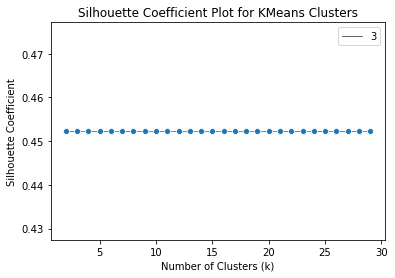

In [51]:
# Plot the silhouette coefficients
elbow_plot = sns.lineplot(x = range(2, 30), y = s_coefficients, 
                          marker="o", size=3)

elbow_plot.set(xlabel = "Number of Clusters (k)", ylabel = 
               "Silhouette Coefficient", title = "Silhouette Coefficient Plot for KMeans Clusters")


# As Alexey had mentioned, the silhouette coefficient does not help 
#     distinguish how many clusters we would need!

In [76]:
s_coefficients

[0.45229874896428557,
 0.45229874896428557,
 0.45229874896428557,
 0.45229874896428557,
 0.45229874896428557,
 0.45229874896428557,
 0.45229874896428557,
 0.45229874896428557,
 0.45229874896428557,
 0.45229874896428557,
 0.45229874896428557,
 0.45229874896428557,
 0.45229874896428557,
 0.45229874896428557,
 0.45229874896428557,
 0.45229874896428557,
 0.45229874896428557,
 0.45229874896428557,
 0.45229874896428557,
 0.45229874896428557,
 0.45229874896428557,
 0.45229874896428557,
 0.45229874896428557,
 0.45229874896428557,
 0.45229874896428557,
 0.45229874896428557,
 0.45229874896428557,
 0.45229874896428557]

### Intermediate Conclusions: 
- It is evident through the elbow method that __ is the optimal number of clusters

In [56]:
# Plotting our clusters!

kmeans = KMeans(n_clusters= 16, **kwargs_for_kmeans)
label = kmeans.fit_predict(df_scaled_tpm)


[ 0  0  0 ... 12  8  8]


In [82]:
len(set(label))

16

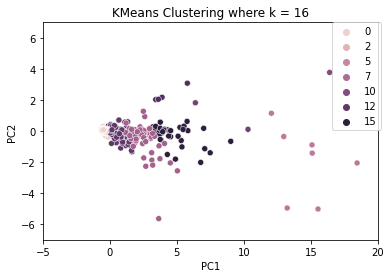

In [75]:
pca = PCA(2)

# Use PCA library in sklearn to fit and transform desired raw tpm data for each sample 
dim_reduced_scaled = pca.fit_transform(df_scaled_tpm)

# create dataframe with array + keep track of conditions so that its easy to grab the colors for plotting
df_dim_reduced_scaled = pd.DataFrame(dim_reduced_scaled)

df_dim_reduced_scaled = df_dim_reduced_scaled.set_axis(["PC1", "PC2"], axis = 1)

ax = sns.scatterplot(x = df_dim_reduced_scaled["PC1"], y = df_dim_reduced_scaled["PC2"], c = label)
ax.set_xlim([-5, 20])
ax.set_ylim([-7, 7])
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.title("KMeans Clustering where k = 16")
plt.show()

In [55]:
>>> iris = load_iris()
>>> pca = PCA(n_components=2).fit(iris.data)
>>> pca_2d = pca.transform(iris.data)
>>> pl.figure('Reference Plot')
>>> pl.scatter(pca_2d[:, 0], pca_2d[:, 1], c=iris.target)
>>> kmeans = KMeans(n_clusters=3, random_state=111)
>>> kmeans.fit(iris.data)
>>> pl.figure('K-means with 3 clusters')
>>> pl.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_)
>>> pl.show()

KMeans(n_clusters=29, random_state=42)